In [ ]:
import torch
import torch.nn as nn
from torchvision.models.resnet import BasicBlock
from torchsummary import summary

class ResNet14(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet14, self).__init__()
        self.inplanes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #(layer1,2 2 block), (layer3,4 1 block), giảm block 2 layer đầu của Residu
        self.layer1 = self._make_layer(BasicBlock, 64,  2)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 1, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 1, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None

        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes

        for _ in range(1, blocks):
            layers.append(block(planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [4]:
model = ResNet14(num_classes=10) 
print(model)

ResNet14(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


In [5]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [6]:
inputs = torch.randint(5, (32, 3, 224, 224), dtype=torch.float32)

In [8]:
predictions = model(inputs)

In [9]:
predictions.shape

torch.Size([32, 10])

In [10]:
import os
import time
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms, models
import torch.utils.data as data
from torch.utils.data import DataLoader

from torchsummary import summary

import matplotlib.pyplot as plt

In [11]:
ROOT = './data'

train_data = datasets.CIFAR10(
    root=ROOT,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.CIFAR10(
    root=ROOT,
    train=False,
    download=True,
    transform=transforms.ToTensor()
    )

100.0%


In [12]:
len(train_data)

50000

In [13]:
train_data.data.shape

(50000, 32, 32, 3)

In [14]:
len(test_data)

10000

In [ ]:
train_data_stack = torch.stack([img for img, _ in train_data], dim=3)
#data dạng tuple nên phải tách label, xong stack

In [ ]:
mean= train_data_stack.view(3,-1).mean(dim=1)
std= train_data_stack.view(3,-1).std(dim=1)
mean, std
#flatten và normalize

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [ ]:
#chuyển sang Tensor
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
train_data.transform = data_transforms
test_data.transform = data_transforms

In [ ]:
BATCH_SIZE = 512

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)

test_dataloader = data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE
)
#512 ảnh 1 batch
#train có shuffle , test không có

In [ ]:
import torch
import torch.nn as nn
from torchvision.models.resnet import BasicBlock
from torchsummary import summary

class ResNet14(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet14, self).__init__()
        self.inplanes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #(layer1,2 2 block), (layer3,4 1 block), giảm block 2 layer đầu của Residu
        self.layer1 = self._make_layer(BasicBlock, 64,  2)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 1, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 1, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None

        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes

        for _ in range(1, blocks):
            layers.append(block(planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [ ]:
model = ResNet14(num_classes=10) 
print(model)

In [ ]:
summary(model, (3, 224, 224))

In [ ]:
inputs = torch.randint(5, (32, 3, 224, 224), dtype=torch.float32)

In [ ]:
predictions = model(inputs)

In [ ]:
predictions.shape

In [ ]:
import os
import time
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms, models
import torch.utils.data as data
from torch.utils.data import DataLoader

from torchsummary import summary

import matplotlib.pyplot as plt

In [ ]:
ROOT = './data'

train_data = datasets.CIFAR10(
    root=ROOT,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.CIFAR10(
    root=ROOT,
    train=False,
    download=True,
    transform=transforms.ToTensor()
    )

In [ ]:
len(train_data)

In [ ]:
train_data.data.shape

In [ ]:
len(test_data)

In [ ]:
train_data_stack = torch.stack([img for img, _ in train_data], dim=3)
#data dạng tuple nên phải tách label, xong stack

In [ ]:
mean= train_data_stack.view(3,-1).mean(dim=1)
std= train_data_stack.view(3,-1).std(dim=1)
mean, std
#flatten và normalize

In [ ]:
#chuyển sang Tensor
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
train_data.transform = data_transforms
test_data.transform = data_transforms

In [ ]:
BATCH_SIZE = 512

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)

test_dataloader = data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE
)
#512 ảnh 1 batch
#train có shuffle , test không có

In [ ]:
len(train_dataloader)
#số batch

In [ ]:
inputs, labels = next(iter(train_dataloader))

In [ ]:
inputs.shape

In [ ]:
def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [ ]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

In [ ]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, len(train_data.classes))

In [ ]:
model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
summary(model, (3, 32, 32))

In [ ]:
summary(model, (3, 224, 224))

In [ ]:
model = ResNet14(num_classes=10) 
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, len(train_data.classes))
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 3
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'model'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader, test_dataloader, num_epochs, device
)


| epoch   1 |    50/   98 batches | accuracy    0.272
-----------------------------------------------------------
| End of epoch   1 | Time: 84.46s | Train Accuracy    0.416 | Train Loss    1.832 | Valid Accuracy    0.408 | Valid Loss    1.641 
-----------------------------------------------------------
| epoch   2 |    50/   98 batches | accuracy    0.488
-----------------------------------------------------------
| End of epoch   2 | Time: 106.58s | Train Accuracy    0.546 | Train Loss    1.340 | Valid Accuracy    0.537 | Valid Loss    1.286 
-----------------------------------------------------------
| epoch   3 |    50/   98 batches | accuracy    0.598
-----------------------------------------------------------
| End of epoch   3 | Time: 90.29s | Train Accuracy    0.629 | Train Loss    1.084 | Valid Accuracy    0.609 | Valid Loss    1.124 
-----------------------------------------------------------


In [ ]:
test_acc, test_loss = evaluate_epoch(model, criterion, test_dataloader, device)
test_acc, test_loss

(0.6088, 1.124450647830963)

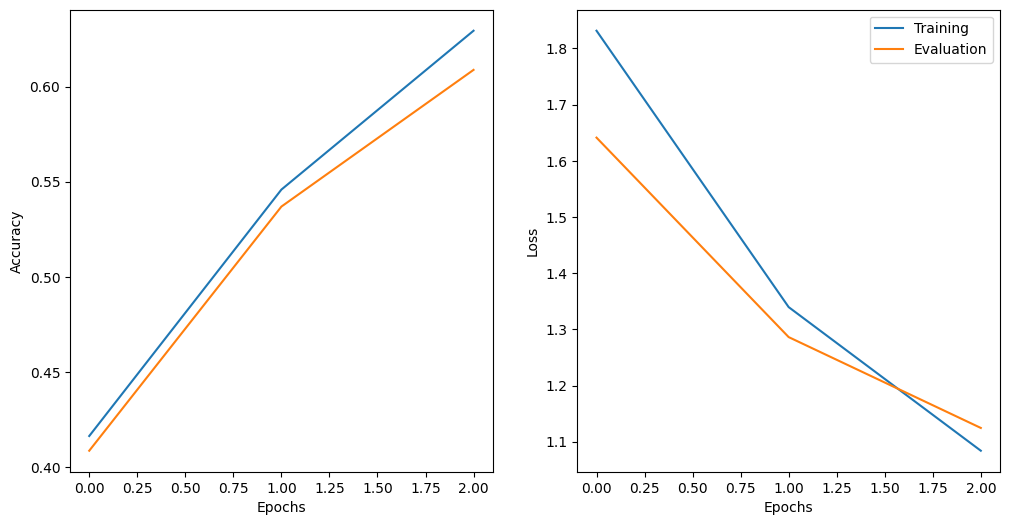

In [ ]:
plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)